# Simple Power Demand Forecasting

This notebook implements a straightforward approach to power demand forecasting:

1. Load and split data
2. Train multiple models
3. Compare results
4. Save best model

Our goal is to predict power demand using time and temperature features.

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
import json  # Added import for JSON handling

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load and Split Data

Load the preprocessed dataset and split it into training, validation, and test sets.

In [22]:
# Load the preprocessed dataset
df = pd.read_csv('processed_load_data.csv')

# Define features and target
features = ['temperature', 'hour', 'weekday', 'month', 'is_weekend', 'season']
target = 'demand'

X = df[features]
y = df[target]

# First split: separate test set (20% of data)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Second split: separate validation set (25% of remaining data = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle=False)

print("Data Split Sizes:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

Data Split Sizes:
Training set: 61,567 samples
Validation set: 20,523 samples
Test set: 20,523 samples


## 2. Train Models

Train two models:
1. Linear Regression (baseline)
2. Random Forest (advanced)

In [23]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}\n")
    
    return {'mae': mae, 'r2': r2}

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train)
lr_val_pred = lr_model.predict(X_val)

# Evaluate Linear Regression
print("Linear Regression Results:")
print("-------------------------")
print("Training Set:")
lr_train_metrics = evaluate_model(y_train, lr_train_pred, "Linear Regression")
print("Validation Set:")
lr_val_metrics = evaluate_model(y_val, lr_val_pred, "Linear Regression")

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)

# Evaluate Random Forest
print("Random Forest Results:")
print("---------------------")
print("Training Set:")
rf_train_metrics = evaluate_model(y_train, rf_train_pred, "Random Forest")
print("Validation Set:")
rf_val_metrics = evaluate_model(y_val, rf_val_pred, "Random Forest")

Linear Regression Results:
-------------------------
Training Set:
Linear Regression Performance:
MAE: 0.1216
R²: 0.3570

Validation Set:
Linear Regression Performance:
MAE: 0.1235
R²: 0.3396

Random Forest Results:
---------------------
Training Set:
Random Forest Performance:
MAE: 0.0184
R²: 0.9781

Validation Set:
Random Forest Performance:
MAE: 0.0407
R²: 0.9155

Random Forest Results:
---------------------
Training Set:
Random Forest Performance:
MAE: 0.0184
R²: 0.9781

Validation Set:
Random Forest Performance:
MAE: 0.0407
R²: 0.9155



## 3. Evaluate on Test Set

Evaluate the best model on the test set and visualize predictions.

Best Model Test Results:
----------------------
Random Forest Performance:
MAE: 0.0454
R²: 0.8889



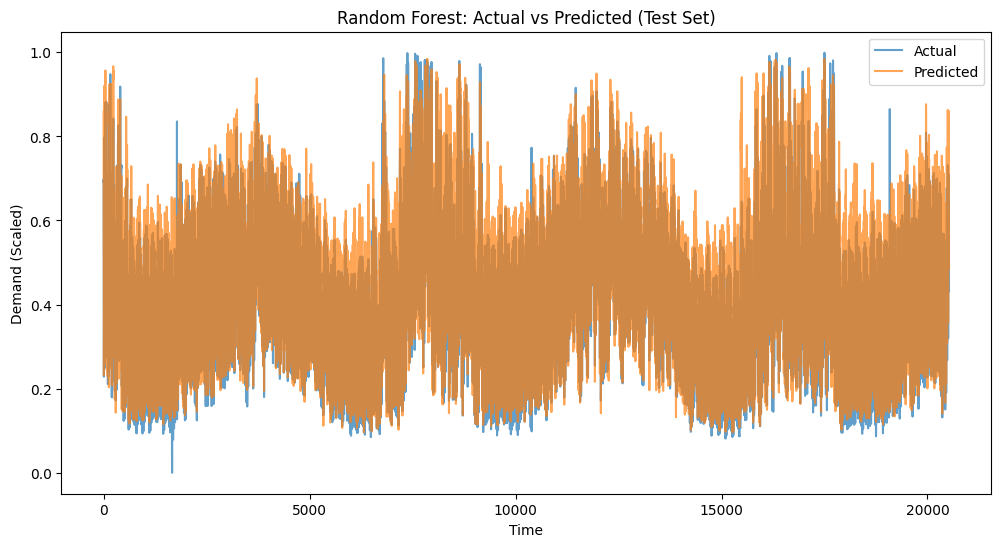

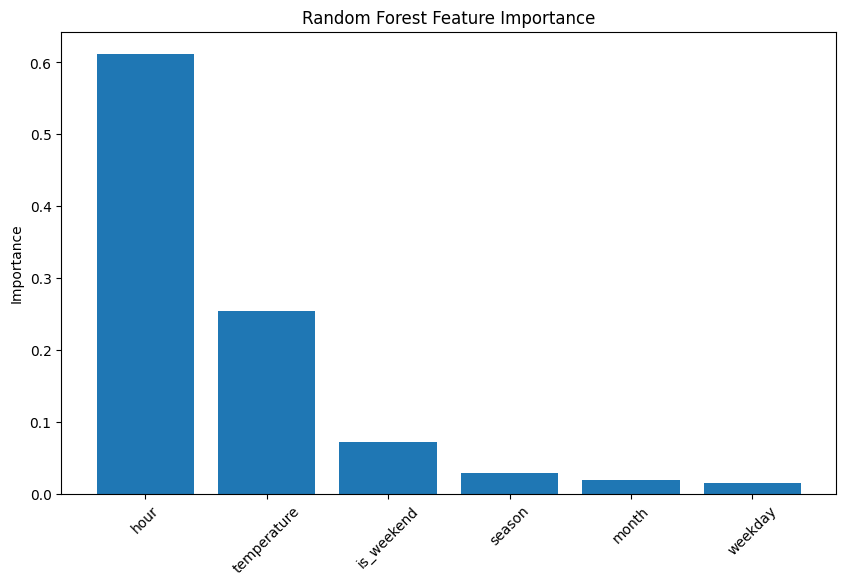

In [24]:
# Choose best model based on validation MAE
if rf_val_metrics['mae'] < lr_val_metrics['mae']:
    best_model = rf_model
    model_name = 'Random Forest'
else:
    best_model = lr_model
    model_name = 'Linear Regression'

# Make predictions on test set
test_pred = best_model.predict(X_test)

# Evaluate on test set
print("Best Model Test Results:")
print("----------------------")
test_metrics = evaluate_model(y_test, test_pred, model_name)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test.values, label='Actual', alpha=0.7)
plt.plot(range(len(test_pred)), test_pred, label='Predicted', alpha=0.7)
plt.title(f'{model_name}: Actual vs Predicted (Test Set)')
plt.xlabel('Time')
plt.ylabel('Demand (Scaled)')
plt.legend()
plt.show()

# Plot feature importance
if model_name == 'Random Forest':
    importance = pd.DataFrame({
        'feature': features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    importance = pd.DataFrame({
        'feature': features,
        'importance': abs(best_model.coef_)
    }).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance['feature'], importance['importance'])
plt.title(f'{model_name} Feature Importance')
plt.xticks(rotation=45)
plt.ylabel('Importance')
plt.show()

## 4. Save Best Model

Save the best performing model for future use.

In [25]:
# Create saved_models directory if it doesn't exist
save_dir = Path('../saved_models')
save_dir.mkdir(exist_ok=True)

# Save model
model_path = save_dir / 'best_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Save model info
model_info = {
    'model_type': model_name,
    'features': features,
    'test_metrics': test_metrics,
    'feature_importance': dict(zip(features, importance['importance'].values))
}

info_path = save_dir / 'model_info.json'
with open(info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"Best model ({model_name}) saved to: {model_path}")
print(f"Model info saved to: {info_path}")

# Example of how to load and use the model
print("\nExample: Loading and using the saved model")
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

# Create a sample input
sample_input = pd.DataFrame({
    'temperature': [0.5],
    'hour': [12],
    'weekday': [1],
    'month': [6],
    'is_weekend': [0],
    'season': [2]
})[features]

# Make prediction
prediction = loaded_model.predict(sample_input)
print("\nSample Prediction:")
print("Input features:", sample_input.iloc[0].to_dict())
print(f"Predicted demand: {prediction[0]:.4f}")

Best model (Random Forest) saved to: ..\saved_models\best_model.pkl
Model info saved to: ..\saved_models\model_info.json

Example: Loading and using the saved model

Sample Prediction:
Input features: {'temperature': 0.5, 'hour': 12.0, 'weekday': 1.0, 'month': 6.0, 'is_weekend': 0.0, 'season': 2.0}
Predicted demand: 0.2577

Sample Prediction:
Input features: {'temperature': 0.5, 'hour': 12.0, 'weekday': 1.0, 'month': 6.0, 'is_weekend': 0.0, 'season': 2.0}
Predicted demand: 0.2577
